# Application Review Vibration

### Ramp idle to 2200

In [1]:
import numpy as np
import scipy
import scipy.fftpack
import scipy.signal as signal
from nptdms import tdms
import matplotlib.pyplot as plt

from acoustics import Signal
from acoustics.standards.iec_61672_1_2013 import (
    NOMINAL_OCTAVE_CENTER_FREQUENCIES,
    NOMINAL_THIRD_OCTAVE_CENTER_FREQUENCIES)

#from stft import *
import sig
#from vib_files import getTdmsFilesInPath
from scripts.limits import Viblimit, getlimits, getlimitfrompath

%matplotlib inline

### Path to TDMS file and Appropriate Limits:

In [2]:
fn = './TDMS/6068/DOC vib/Vibration Log_2018-05-14 - 155152.tdms'
print(fn)

./TDMS/6068/DOC vib/Vibration Log_2018-05-14 - 155152.tdms


In [3]:
tdmspath = fn
print(getlimitfrompath(fn))
lim = getlimitfrompath(fn)
tdfile = tdms.TdmsFile(tdmspath)

Processing DOC LIMIT
Viblimit.DOC2
Processing DOC LIMIT


In [4]:
tdfile.object().properties

OrderedDict([('DSA Hdw', 'NI-9234'),
             ('Date', '2018-05-14'),
             ('Title', 'DISTek'),
             ('After Test Comments', ''),
             ('Test Location', ''),
             ('Test Operator', ''),
             ('Test Comments', '')])

### Setup Data Structures and Perform Standard calculations

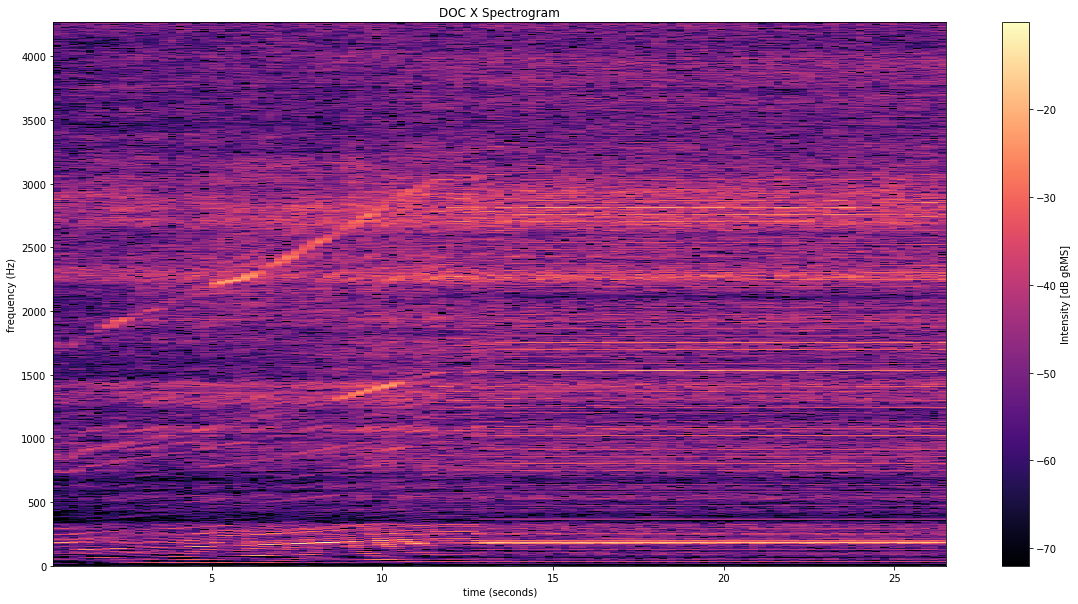

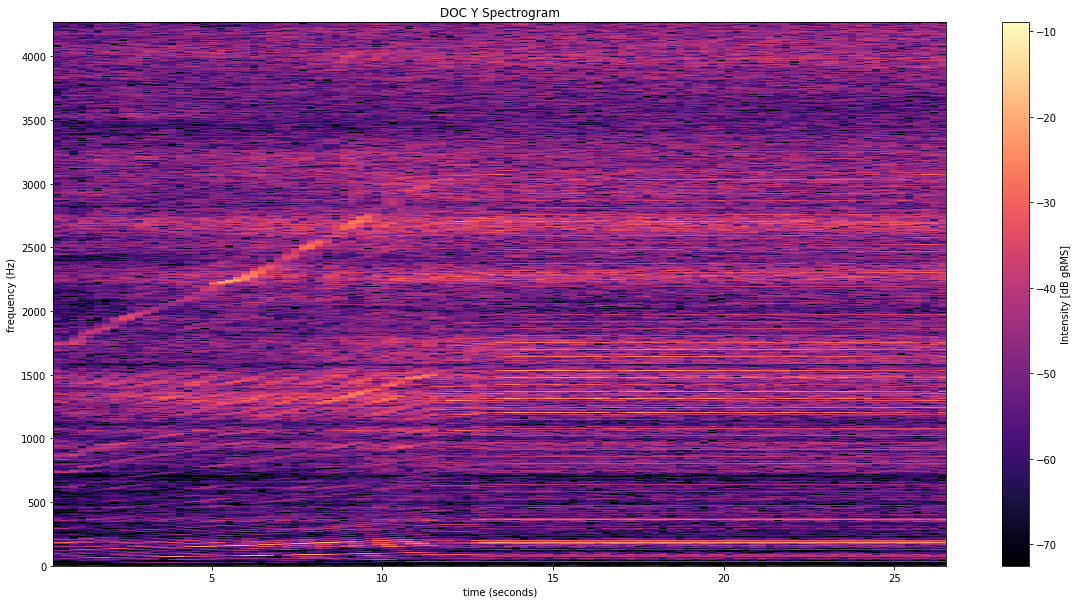

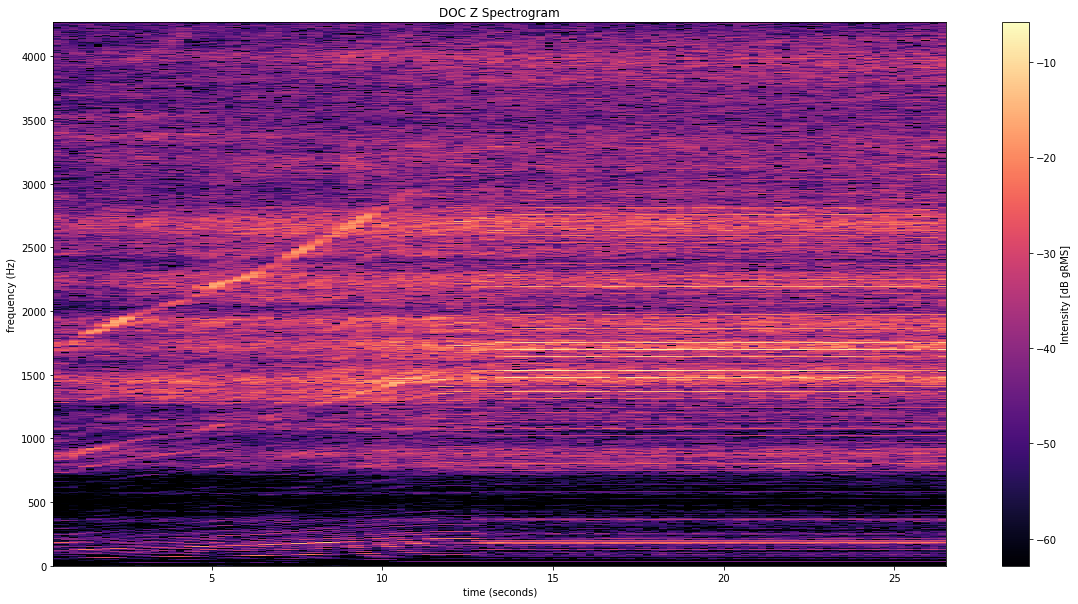

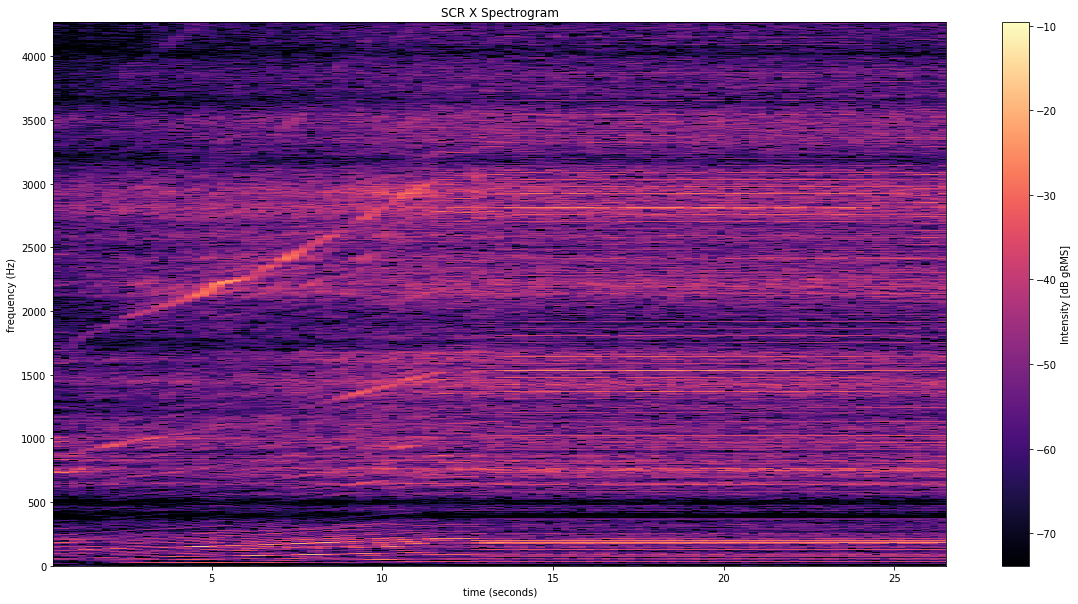

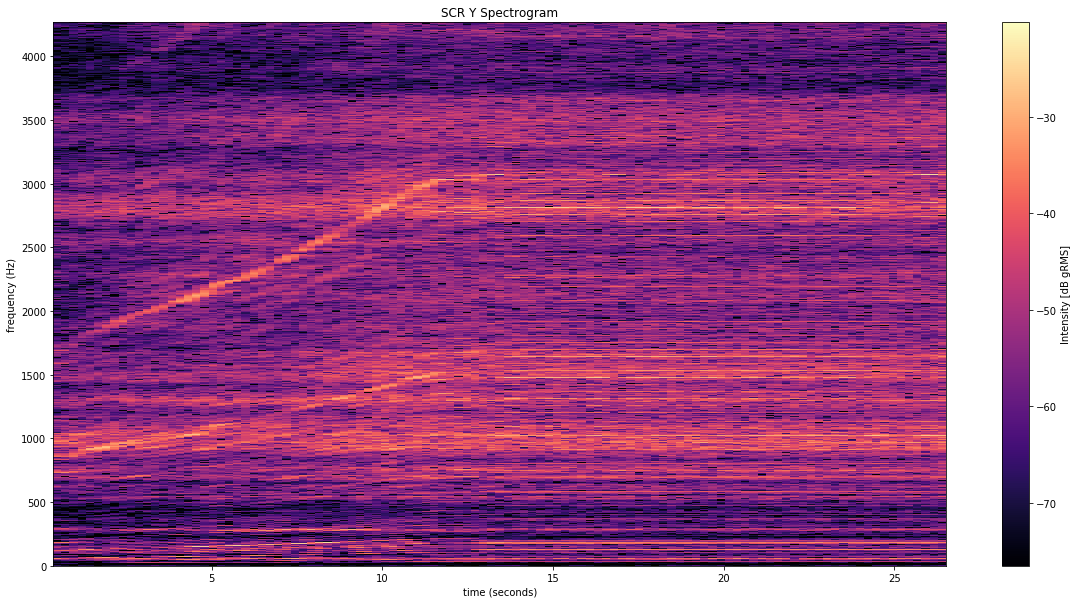

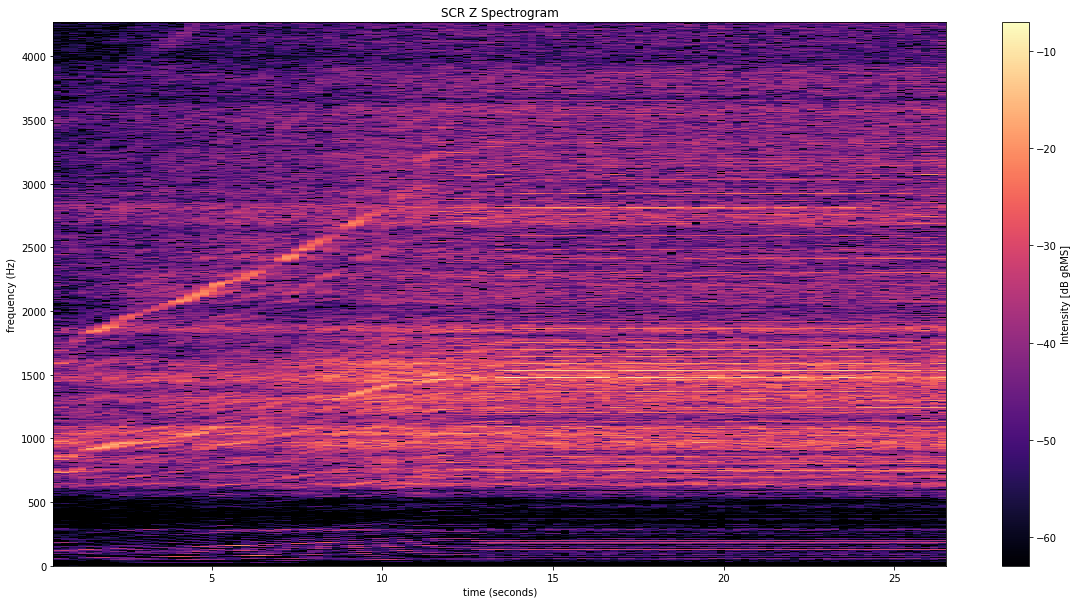

In [5]:
for channel in tdfile.group_channels('Vibration'):
    chName = (channel.properties['NI_ChannelName'])
    DOCSensitivity = float(channel.properties['Sensor Sensitivity (mV/EU)'])
    data = (channel.data * 1000 / DOCSensitivity)

    fig, ax = plt.subplots()
    fig.set_size_inches(20,10)
    
    ax.set_title(chName + ' Spectrogram')
    ax.set_xlabel('time (seconds)')
    ax.set_ylabel('frequency (Hz)')
    
    NFFT = 8192
    cmap = plt.get_cmap('magma')
    vmin = 20*np.log10(np.max(data)) - 80 #clamp to -80 dB
    cmap.set_under(color='k', alpha=None)
    
    pxx, freq, t, cax = plt.specgram(data, NFFT=NFFT, Fs=8533.3333, Fc=None, 
                                     detrend=None, window=np.hanning(8192), mode='psd', 
                                     noverlap=NFFT*0.75, pad_to=None, cmap=cmap, vmin=vmin, scale='dB')
    fig.colorbar(cax).set_label('Intensity [dB gRMS]')
    plt.show()


### Plot overall Run.  Look at index at bottom for more detailed plot in next cell.

/Users/jack/work/jggeng/git/apprev-vib/sig.py:899: RuntimeWarning: divide by zero encountered in log10
  level = 10.0*np.log10(power / ref**2.0)


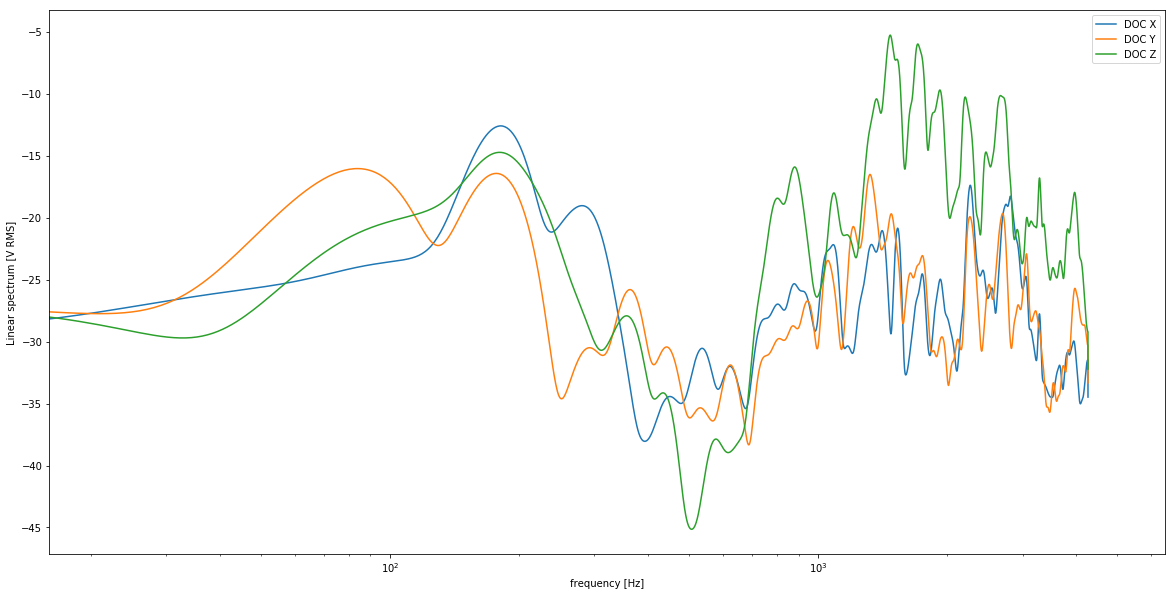

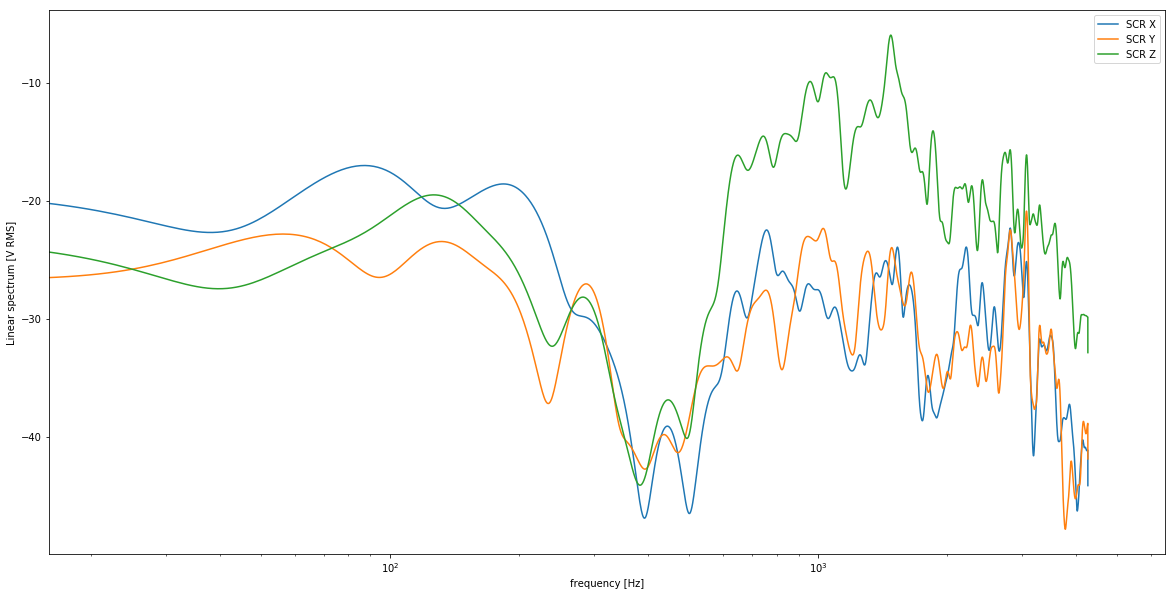

In [6]:
win = np.hanning(8192)
PLOT_MIN = -60 #dB
n_frequencies = 8

class Axis():
    pass

axis = Axis()

axis.Name = []

axis.f = []
axis.Pxx = []

axis.octave_data = []
axis.octave_limits = []
axis.labels = []


for channel in tdfile.group_channels('Vibration'):
    #Get Metadata from tdms channel
    chName = (channel.properties['NI_ChannelName'])
    Sensitivity = float(channel.properties['Sensor Sensitivity (mV/EU)'])
    data = (channel.data * 1000 / Sensitivity)
    axis.Name.append(chName)
   
    #generate PSD
    f, Pxx_spec = signal.welch(data, fs=8533, window='hann', nfft=8192, detrend=None, scaling='spectrum')
    axis.f.append(f)
    axis.Pxx.append(10*np.log10(Pxx_spec))
    
    #generate Octave Bands
    s = Signal(data, fs=8533)
    sx = np.array(s)
    x = sig.apply_window(sx, win)
    octdata = sig.octaves(x, s.fs, density=False, frequencies=NOMINAL_OCTAVE_CENTER_FREQUENCIES, ref=1.0)
    
    labels = []
    for i in octdata[0][:9]:
        labels.append(str(round(float(i.center), 2))+' Hz')
    
    # data to plot
    octave_data = octdata[1][:n_frequencies]
    octave_limits = getlimits(index=lim.value)[:n_frequencies]   #(-8.40, -1.31, 3.35, 9.07, 4.19, 4.14, 6, 6, 6)
    shifted_limits = np.array(octave_limits)
    shifted_limits = (shifted_limits - PLOT_MIN)
    
    axis.octave_data.append(octave_data)
    axis.octave_limits.append(shifted_limits)
    axis.labels.append(labels)

    
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
    
for i in range(0, 3):
    ax.semilogx(axis.f[i], axis.Pxx[i], label=axis.Name[i])

plt.xlabel('frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
plt.xlim(xmin=16)
plt.legend()
plt.show()


fig, ax = plt.subplots()
fig.set_size_inches(20,10)
    
for i in range(3, 6):
    ax.semilogx(axis.f[i], axis.Pxx[i], label=axis.Name[i])

plt.xlabel('frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
plt.xlim(xmin=16)
plt.legend()
plt.show()


index = 0
octave_data = [-48.69812759 -28.54510273 -24.77929649 -17.01812464 -12.02346609
 -25.32045313 -13.45350958  -8.90379915]
axis.Name == DOC X
index = 1
octave_data = [-60.91996593 -36.34122652 -17.37637162 -17.0400787  -17.85874014
 -23.01791793 -11.74261225  -9.75086676]
axis.Name == DOC Y
index = 2
octave_data = [-61.30199279 -38.57519561 -23.71578823 -15.79580666 -14.48790499
 -26.71418386  -5.49658443   3.30890381]
axis.Name == DOC Z


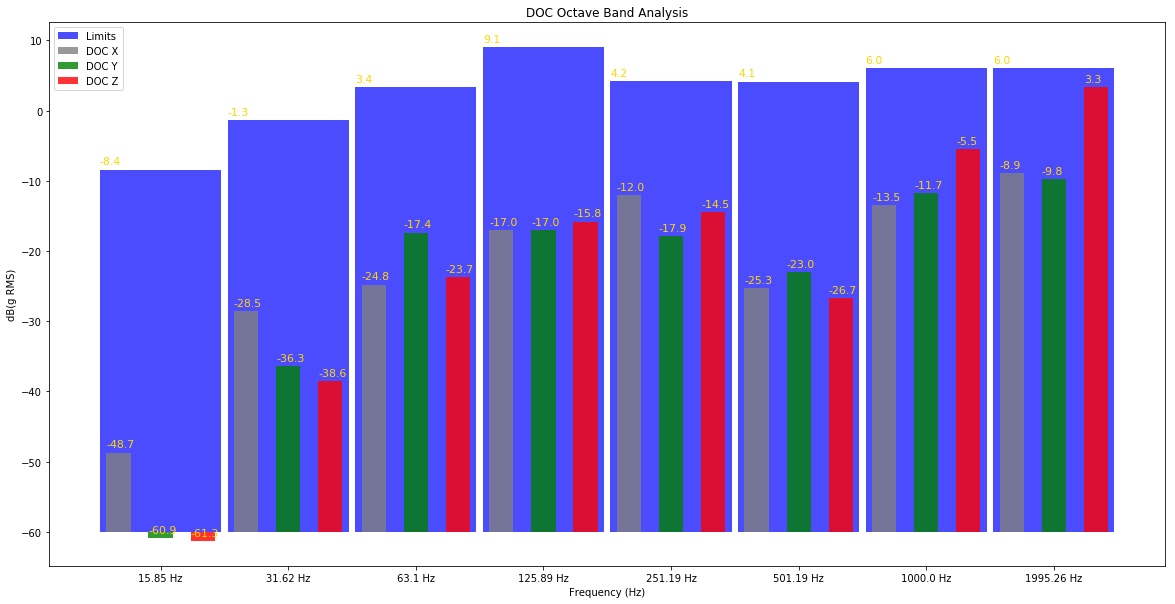

In [7]:
fig, ax = plt.subplots(figsize=(20,10))

index = np.arange(n_frequencies)
bar_width = 0.95
opacity = 0.8
#ax.set_facecolor('darkgrey')
rectsLimits = plt.bar(index,
                 shifted_limits, bar_width, bottom=PLOT_MIN,
                 alpha=.7,
                 color='b',
                 label='Limits')

rects = []
colors = ['grey', 'green', 'red']

for i in range(0, 3):
    #ax.semilogx(axis.f[i], axis.Pxx[i], label=axis.Name[i])
    # create plot
    print('index = {0}'.format(i))
    print('octave_data = {}'.format(axis.octave_data[i]))
    print('axis.Name == {0}'.format(axis.Name[i]))
    rects.append(plt.bar(index + .33 * (i - 1), axis.octave_data[i] - PLOT_MIN, bar_width*.20, bottom=PLOT_MIN,
                     alpha=opacity,
                     color=colors[i],
                     label=axis.Name[i]))
    
plt.xlabel('Frequency (Hz)')
plt.ylabel('dB(g RMS)')
plt.title(axis.Name[0][:-2] + ' Octave Band Analysis')
plt.xticks(index, labels)
plt.legend()

for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    #if i.label == 'Limits':
    #    ax.text(i.get_x()+.5, i.get_height()+PLOT_MIN+.75, \
    #    str(round((i.get_height()+PLOT_MIN), 1)), fontsize=12, color='black')
        
    ax.text(i.get_x(), i.get_height()+PLOT_MIN+.75, \
    str(round((i.get_height()+PLOT_MIN), 1)), fontsize=11, color='gold')

#plt.tight_layout()
plt.legend()
#fig.patch.set_facecolor('grey')
plt.show()
    

index = 3
octave_data = [-50.49878401 -29.74112174 -19.50138707 -16.87964816 -17.85709193
 -25.16239498 -16.23068606 -13.54899669]
axis.Name == SCR X
index = 4
octave_data = [-63.39609118 -38.20157502 -23.07618817 -22.23147732 -24.55029477
 -26.00169439 -14.80135488 -15.03688668]
axis.Name == SCR Y
index = 5
octave_data = [-61.53377591 -44.01512912 -24.69638295 -18.23883033 -23.90683647
 -13.64932518  -1.04080875  -0.47039178]
axis.Name == SCR Z


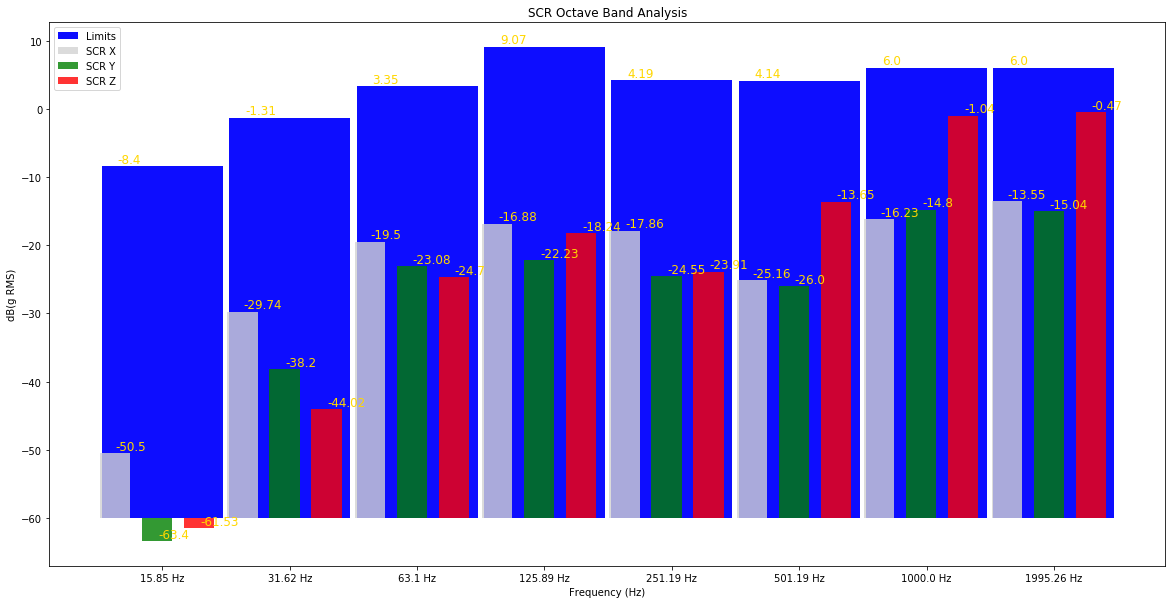

In [8]:
fig, ax = plt.subplots(figsize=(20,10))

index = np.arange(n_frequencies)
bar_width = 0.95
opacity = 0.8

rectsLimits = plt.bar(index,
                 shifted_limits, bar_width, bottom=PLOT_MIN,
                 alpha=.95,
                 color='b',
                 label='Limits')

rects = []
colors = ['lightgrey', 'green', 'red']

for i in range(3, 6):
    #ax.semilogx(axis.f[i], axis.Pxx[i], label=axis.Name[i])
    # create plot
    print('index = {0}'.format(i))
    print('octave_data = {}'.format(axis.octave_data[i]))
    print('axis.Name == {0}'.format(axis.Name[i]))
    rects.append(plt.bar(index + .33 * ((i-3) - 1.125), axis.octave_data[i] - PLOT_MIN, bar_width*.25, bottom=PLOT_MIN,
                     alpha=opacity,
                     color=colors[i-3],
                     label=axis.Name[i]))
    
plt.xlabel('Frequency (Hz)')
plt.ylabel('dB(g RMS)')
plt.title(axis.Name[3][:-2] + ' Octave Band Analysis')
plt.xticks(index, labels)
plt.legend()

for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.125, i.get_height()+PLOT_MIN+.5, \
    str(round((i.get_height()+PLOT_MIN), 2)), fontsize=12, color='gold')

#plt.tight_layout()
plt.legend()
plt.show()